In [239]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)


Mounted at /content/drive


In [240]:
cd /content/drive/My Drive/CIS581-CannyEdge

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py", line 2882, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-240-deaf7c898f58>", line 1, in <module>
    get_ipython().magic('cd /content/drive/My Drive/CIS581-CannyEdge')
  File "/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py", line 2160, in magic
    return self.run_line_magic(magic_name, magic_arg_s)
  File "/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py", line 2081, in run_line_magic
    result = fn(*args,**kwargs)
  File "<decorator-gen-84>", line 2, in cd
  File "/usr/local/lib/python3.7/dist-packages/IPython/core/magic.py", line 188, in <lambda>
    call = lambda f, *a, **k: f(*a, **k)
  File "/usr/local/lib/python3.7/dist-packages/IPython/core/magics/osm.py", line 288, in cd
    oldcwd = py3compat.getcwd()
OSError: [Errno 107] Transport endpoint is not connected

During handl

OSError: ignored

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
from scipy import signal
from PIL import Image
import argparse

# Copy the path of the folder that contains this notebook using the file navigation on the left:
# Ex. /content/drive/My\ Drive/CIS 581-Online/Canny Edge Project/Learner Code and Images/Code
sys.path.append('/content/drive/MyDrive/CIS581-CannyEdge')

# import functions
from helpers import interp2

# Tests and Visualization

In [ ]:
def Test_script(I, E):
    test_pass = True

    # E should be 2D matrix
    if E.ndim != 2:
      print('ERROR: Incorrect Edge map dimension! \n')
      print(E.ndim)
      test_pass = False
    # end if

    # E should have same size with original image
    nr_I, nc_I = I.shape[0], I.shape[1]
    nr_E, nc_E = E.shape[0], E.shape[1]

    if nr_I != nr_E or nc_I != nc_E:
      print('ERROR: Edge map size has changed during operations! \n')
      test_pass = False
    # end if

    # E should be a binary matrix so that element should be either 1 or 0
    numEle = E.size
    numOnes, numZeros = E[E == 1].size, E[E == 0].size

    if numEle != (numOnes + numZeros):
      print('ERROR: Edge map is not binary one! \n')
      test_pass = False
    # end if

    if test_pass:
      print('Shape Test Passed! \n')
    else:
      print('Shape Test Failed! \n')

    return test_pass

In [ ]:
'''
  Derivatives visualzation function
'''
def visDerivatives(I_gray, Mag, Magx, Magy):
    fig, (Ax0, Ax1, Ax2, Ax3) = plt.subplots(1, 4, figsize = (20, 8))

    Ax0.imshow(Mag, cmap='gray', interpolation='nearest')
    Ax0.axis('off')
    Ax0.set_title('Gradient Magnitude')

    Ax1.imshow(Magx, cmap='gray', interpolation='nearest')
    Ax1.axis('off')
    Ax1.set_title('Gradient Magnitude (x axis)')
    
    Ax2.imshow(Magy, cmap='gray', interpolation='nearest')
    Ax2.axis('off')
    Ax2.set_title('Gradient Magnitude (y axis)')

    # plot gradient orientation
    Mag_vec = Mag.transpose().reshape(1, Mag.shape[0] * Mag.shape[1]) 
    hist, bin_edge = np.histogram(Mag_vec.transpose(), 100)

    ind_array = np.array(np.where( (np.cumsum(hist).astype(float) / hist.sum()) < 0.95))
    thr = bin_edge[ind_array[0, -1]]

    ind_remove = np.where(np.abs(Mag) < thr)
    Magx[ind_remove] = 0
    Magy[ind_remove] = 0

    X, Y = np.meshgrid(np.arange(0, Mag.shape[1], 1), np.arange(0, Mag.shape[0], 1))
    Ori = np.arctan2(Magy, Magx)
    ori = Ax3.imshow(Ori, cmap='hsv')
    Ax3.axis('off')
    Ax3.set_title('Gradient Orientation')
    fig.colorbar(ori, ax=Ax3, )
    


'''
  Edge detection result visualization function
'''
def visCannyEdge(Im_raw, M, E):
    # plot image
    fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize = (12, 12))

    # plot original image
    ax0.imshow(Im_raw)
    ax0.axis("off")
    ax0.set_title('Raw image')

    # plot edge detection result
    ax1.imshow(M, cmap='gray', interpolation='nearest')
    ax1.axis("off")
    ax1.set_title('Non-Max Suppression Result')

    # plot original image
    ax2.imshow(E, cmap='gray', interpolation='nearest')
    ax2.axis("off") 
    ax2.set_title('Canny Edge Detection')

# Functions

In [ ]:
'''
  Convert RGB image to gray one manually
  - Input I_rgb: 3-dimensional rgb image
  - Output I_gray: 2-dimensional grayscale image
'''
def rgb2gray(I_rgb):
    r, g, b = I_rgb[:, :, 0], I_rgb[:, :, 1], I_rgb[:, :, 2]
    I_gray = 0.2989 * r + 0.5870 * g + 0.1140 * b
    return I_gray

In [ ]:
def findDerivatives(I_gray):
    '''
    File clarification:
        Compute gradient information of the input grayscale image
        - Input I_gray: H x W matrix as image
        - Output Mag: H x W matrix represents the magnitude of derivatives
        - Output Magx: H x W matrix represents the magnitude of derivatives along x-axis
        - Output Magy: H x W matrix represents the magnitude of derivatives along y-axis
        - Output Ori: H x W matrix represents the orientation of derivatives
    '''
    # TODO: complete function
  
    #Gaussian filter
    G = np.array([[2, 4, 5, 4, 2],
                 [4, 9, 12, 9 ,4],
                 [5, 12, 15, 12, 5],
                 [4, 9, 12, 9, 4],
                 [2, 4, 5 ,4 ,2]])
    
    G = G/159
    dx = np.array([[1, 0, -1],
                  [2, 0, -2],
                  [1, 0, -1]])
    
    dy = np.array([[1, 2, 1],
                   [0, 0, 0],
                   [-1, -2, -1]])
    
    #Convolve Gaussian and derivatiive filter

    Gx = signal.convolve2d(G, dx, 'same')
    Gy = signal.convolve2d(G, dy, 'same')


    #compute directional magnitude

    Magx = signal.convolve2d(I_gray, Gx, 'same')
    Magy = signal.convolve2d(I_gray, Gy, 'same')

    #compute total magnitude and angle of gradient

    Mag = np.sqrt(np.square(Magx) + np.square(Magy))
    Ori = np.arctan2(Magy, Magx)

    return Mag, Magx, Magy, Ori

In [ ]:
## Test ##

# you may need to change the path to I1.jpg under Images folder
I = plt.imread('Images/I1.jpg')
Mag, Magx, Magy, Ori = findDerivatives(I)
print(Ori)
assert np.allclose(Mag, np.load('Mag.npy'))
assert np.allclose(Magx, np.load('Magx.npy'))
assert np.allclose(Magy, np.load('Magy.npy'))
assert np.allclose(Ori, np.load('Ori.npy'))

In [243]:
def nonMaxSup(Mag, Ori):
    '''
    File clarification:
        Find local maximum edge pixel using NMS along the line of the gradient
        - Input Mag: H x W matrix represents the magnitude of derivatives
        - Input Ori: H x W matrix represents the orientation of derivatives
        - Output M: H x W binary matrix represents the edge map after non-maximum suppression
    '''
    nc, nr = Mag.shape[1], Mag.shape[0]

    Ori = np.pad(Ori, 1, mode = 'constant')

    # getting neighbor in the oritention direction
    x, y = np.meshgrid(np.arange(nc+2),np.arange(nr+2))
    x_next, y_next = x + np.cos(Ori), y + np.sin(Ori)
    x_prev, y_prev = x - np.cos(Ori), y - np.sin(Ori)

    # use interp2 to get pixel values of the neighbors
    neighbor1 = interp2(np.pad(Mag, 1, mode = 'constant'), x_next, y_next) 

    # getting neighbor in the opposite of the orientation direction
    neighbor2 = interp2(np.pad(Mag, 1, mode = 'constant'), x_prev, y_prev)
    # print(neighbor1)

    # print(x_prev.shape)
    # print(x_prev[0])

    # # convert edge cases to zero    
    # neighbor1[y,x] = np.where(np.logical_or(x_next[y,x]>(nc-1),y_next[y,x]>(nr-1)),0,neighbor1[y,x])
    # # neighbor1[y,x] = np.where(np.logical_or(x_next[y,x]<0,y_next[y,x]<0),0,neighbor1[y,x])

    # neighbor2[y,x] = np.where(np.logical_or(x_prev[y,x]>(nc-1),y_prev[y,x]>(nr-1)),0,neighbor2[y,x])
    # # neighbor2[y,x] = np.where(np.logical_or(x_prev[y,x]<0,y_prev[y,x]<0),0,neighbor2[y,x])
    # plt.imshow(Mag)
    

    # perform NMS
    M = (Mag>= neighbor1[1:-1,1:-1]) & (Mag>= neighbor2[1:-1,1:-1]) 
    """M must be a binary array"""
    # print(M)
    return M


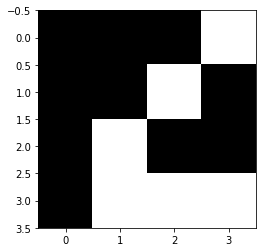

In [244]:

## Test ##
Mag = np.array([[0, 2, 12, 16],
                [4, 9, 11, 8],
                [7, 17, 12, 9],
                [0, 19, 21, 17]])
Ori = np.array([[np.pi/2, np.pi/4, 0, np.pi/4],
                [np.pi/4, np.pi/4, np.pi/4, np.pi/2],
                [np.pi/4, 0, np.pi/2, np.pi/4],
                [np.pi/2, np.pi/4, np.pi/2, np.pi/4]])
res = np.array([[False, False, False,  True],
       [False, False,  True, False],
       [False,  True, False, False],
       [False,  True,  True,  True]])
M = nonMaxSup(Mag, Ori)
plt.imshow(M, cmap='gray')
assert M.dtype == bool
assert M.shape == Mag.shape
assert np.allclose(M, res)

In [ ]:
def edgeLink(M, Mag, Ori, low, high):
    '''
    File clarification:
        Use hysteresis to link edges based on high and low magnitude thresholds
        - Input M: H x W logical map after non-max suppression
        - Input Mag: H x W matrix represents the magnitude of gradient
        - Input Ori: H x W matrix represents the orientation of gradient
        - Input low, high: low and high thresholds 
        - Output E: H x W binary matrix represents the final canny edge detection map
    '''
    

    nc, nr = Mag.shape[1], Mag.shape[0]
    x, y = np.meshgrid(np.arange(nc+2),np.arange(nr+2))

    # initial EdgeMap with strong edges
    strong = np.logical_and(M, (Mag > high))

    # Identify uncertain edges
    weak = np.logical_and(M,(np.logical_and(Mag>low, Mag<high)))

    # compute the edge direction from Ori
    edgeDir = np.pad((Ori + (np.pi/2)), 1, mode = 'constant')

    # find neighbors in the edge direction
    x_next, y_next = x + np.cos(edgeDir), y + np.sin(edgeDir)
    x_prev, y_prev = x - np.cos(edgeDir), y - np.sin(edgeDir)

    while True:

      neighbor1 = interp2(np.pad(strong, 1, mode = 'constant'), x_next, y_next)
      neighbor2 = interp2(np.pad(strong, 1, mode = 'constant'), x_prev, y_prev)

      nearStrongPoints = np.logical_or((neighbor1[1:-1, 1:-1] * weak >= 0.5), (neighbor2[1:-1, 1:-1] * weak >= 0.5))
      strong = np.logical_or(strong, nearStrongPoints)
      weak = np.logical_xor(weak, nearStrongPoints)

      if not nearStrongPoints.any():
        break
        """Make uncertain edge a strong edge to deal with weak-weak-stron case and remove from uncertain map """

    return strong

In [ ]:
## Test ##
M = np.array([[True, False, True,  True],
              [False, True,  True, True],
              [True,  True, False, False],
              [False,  True,  True,  True]])
Mag = np.array([[12, 9, 14, 16],
                [4, 11, 40, 18],
                [13, 12, 30, 15],
                [28, 15, 21, 8]])
Ori = np.array([[np.pi/2, np.pi/4, 0, np.pi/4],
                [np.pi/4, np.pi/4, np.pi/4, np.pi/2],
                [np.pi/4, 0, np.pi/2, np.pi/4],
                [np.pi/2, np.pi/4, np.pi/2, np.pi/4]])
res = np.array([[False, False,  True,  True],
       [False,  True,  True,  True],
       [ True,  True, False, False],
       [False, False,  True, False]])
low, high = 10, 20
E = edgeLink(M, Mag, Ori, low, high)
# print(E)
assert E.dtype == bool
assert E.shape == Mag.shape
assert np.allclose(E, res)

In [ ]:
def cannyEdge(I, low, high):
    # convert RGB image to gray color space
    im_gray = rgb2gray(I)

    Mag, Magx, Magy, Ori = findDerivatives(im_gray)
    M = nonMaxSup(Mag, Ori)
    E = edgeLink(M, Mag, Ori, low, high)

    # only when test passed that can show all results
    if Test_script(im_gray, E):
        # visualization results
        visDerivatives(im_gray, Mag, Magx, Magy)
        visCannyEdge(I, M, E)

        plt.show()

    return E

## Simple image test cases
First, let's try to detect edges in two simple images.

![checkerboard.jpg](Test_Images/rotated_checkerboard.jpg)

For the rotated checkerboard, We should be able to get edges in both directions.

![checkerboard_res.jpg](Test_Images/rotated_checkerboard_Result.png)

![coins.png](Test_Images/coins.png) 

For coins, we should be able to detect circles.

![coins.png](Test_Images/coins_Result.png) 

In [ ]:
# tuning threshold for simple test images
image_folder = "Images"
save_folder = "Results" # need to create this folder in the drive
filename='189080.jpg' # TODO: change image name 
I = np.array(Image.open(os.path.join(image_folder, filename)).convert('RGB'))
low, high = 20,30
E = cannyEdge(I, low, high)
pil_image = Image.fromarray(E.astype(np.uint8) * 255).convert('L')
# check the result in the folder
pil_image.save(os.path.join(save_folder, "{}_Result.png".format(filename.split(".")[0])))

## Tune the threshold for each images under "Image" folder

In [ ]:
 # list all image names
 os.listdir('Images')

In [ ]:
# tuning threshold for a single image
image_folder = "Images"
save_folder = "Results" # need to create this folder in the drive
filename='yosemite.jpg' # TODO: change image name 
I = np.array(Image.open(os.path.join(image_folder, filename)).convert('RGB'))
low, high = 0, 100
E = cannyEdge(I, low, high)
pil_image = Image.fromarray(E.astype(np.uint8) * 255).convert('L')
# check the result in the folder
pil_image.save(os.path.join(save_folder, "{}_Result.png".format(filename.split(".")[0])))

# Fill in all tuned threshold to generate edge detection results


In [ ]:
# keep results for all images
image_folder = "Images"
save_folder = "Results"
# fill in the threshold (low, high) you have tuned in the cell above 
thresh_dict = {'118035.jpg': (0, 5),
                '135069.jpg': (0, 5),
                '16068.jpg': (0, 55),
                '189080.jpg': (0, 30),
                '201080.jpg': (0, 30),
                '21077.jpg': (0, 40),
                '22013.jpg': (0, 45),
                '3096.jpg': (0, 15),
                '48017.jpg': (0, 35),
                '55067.jpg': (0, 7),
                '86000.jpg': (20,60),
                'I1.jpg': (0, 5)}
# generate results one by one
for filename in os.listdir(image_folder):
    # read in image 
    im_path = os.path.join(image_folder, filename)
    I = np.array(Image.open(im_path).convert('RGB'))

    low, high = thresh_dict[filename]
    E = cannyEdge(I, low, high)

    pil_image = Image.fromarray(E.astype(np.uint8) * 255).convert('L')

    pil_image.save(os.path.join(save_folder, "{}_Result.png".format(filename.split(".")[0])))